In [1]:
#Import the dataset

from keras.datasets.fashion_mnist import load_data
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


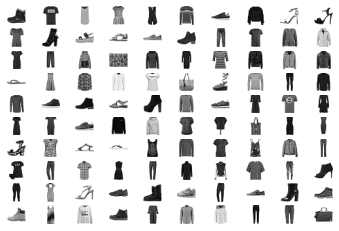

In [3]:
for i in range(100):
  plt.subplot(10, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i], cmap = 'gray_r')
plt.show()  

In [4]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

In [5]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import Activation

In [6]:
#generator is complicated - the class labels are treated as a single 7*7 feature map
#the sample from the latent space to generate an image is also visualized as a 7*7 of multiple channels
#then it can be merged

#the class label is learnt as an embedding of shape 50
def def_generator(latent_dims, n_classes = 10):
  w_init = RandomNormal(stddev = 0.02)
  label = Input(shape = (1, ))
  embedding = Embedding(n_classes, 50)(label)
  n_nodes = 7*7
  embedding = Dense(n_nodes, kernel_initializer= w_init)(embedding)
  embedding = Reshape((7, 7, 1))(embedding)

  #each input latent point that is used to generate an img is represented as a feature map
  latent = Input(shape=(latent_dims, ))
  num_nodes = 384*7*7
  x = Dense(num_nodes, kernel_initializer= w_init)(latent)
  x = Activation('relu')(x)
  x = Reshape((7, 7, 384))(x)
  merged = Concatenate()([x, embedding])

  #start upsampling to generate the image
  gen = Conv2DTranspose(192, (5, 5), strides = (2, 2), padding = 'same', kernel_initializer = w_init)(merged)
  gen = BatchNormalization()(gen)
  gen = Activation('relu')(gen)
  gen = Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', kernel_initializer = w_init)(gen)
  out = Activation('tanh')(gen)
  model = Model([latent, label], out)
  return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 18816)        1900416     input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        500         input_1[0][0]                    
_______________________________________________________________________________________

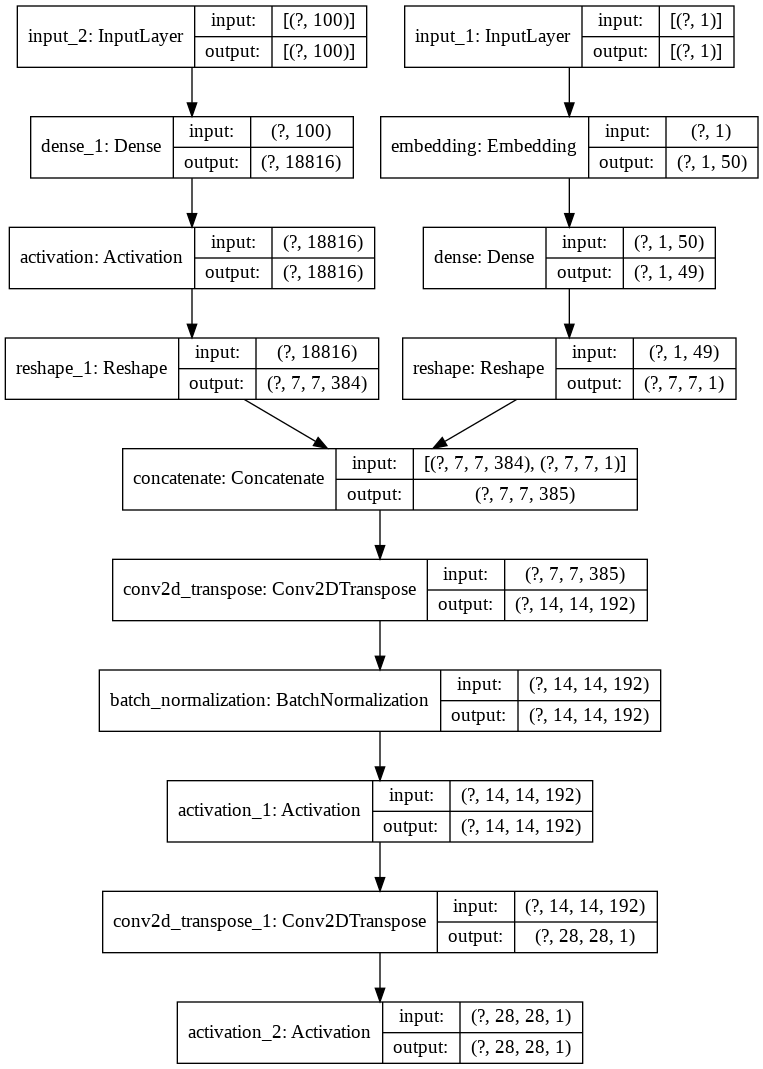

In [7]:
latent_dims = 100
model = def_generator(latent_dims)
model.summary()
plot_model(model, to_file = 'generator.png', show_shapes=True, show_layer_names= True)

In [8]:
def def_discriminator(input_shape = (28, 28, 1), n_classes = 10):
  w_init = RandomNormal(stddev = 0.02)
  input_img = Input(shape = input_shape)
  x = Conv2D(32, (3, 3), strides = (2, 2), padding = 'same', kernel_initializer= w_init)(input_img)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Dropout(0.5)(x)

  x = Conv2D(64, (3,3), padding='same', kernel_initializer = w_init)(x) 
  #stride is 1
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Dropout(0.5)(x)  

  x = Conv2D(128, (3,3), strides = (2, 2), padding='same', kernel_initializer = w_init)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.5)(x)

  x = Conv2D(256, (3,3), padding='same', kernel_initializer = w_init)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.5)(x)

  x = Flatten()(x)
  output1 = Dense(1, activation = 'sigmoid')(x) #real or fake classification

  output2 = Dense(n_classes, activation = 'softmax')(x)
  model = Model(input_img, [output1, output2])
  optimizer = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss = ['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer = optimizer)

  return model

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 14, 14, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 14, 14, 32)   0           leaky_re_lu[0][0]                
_______________________________________________________________________________________

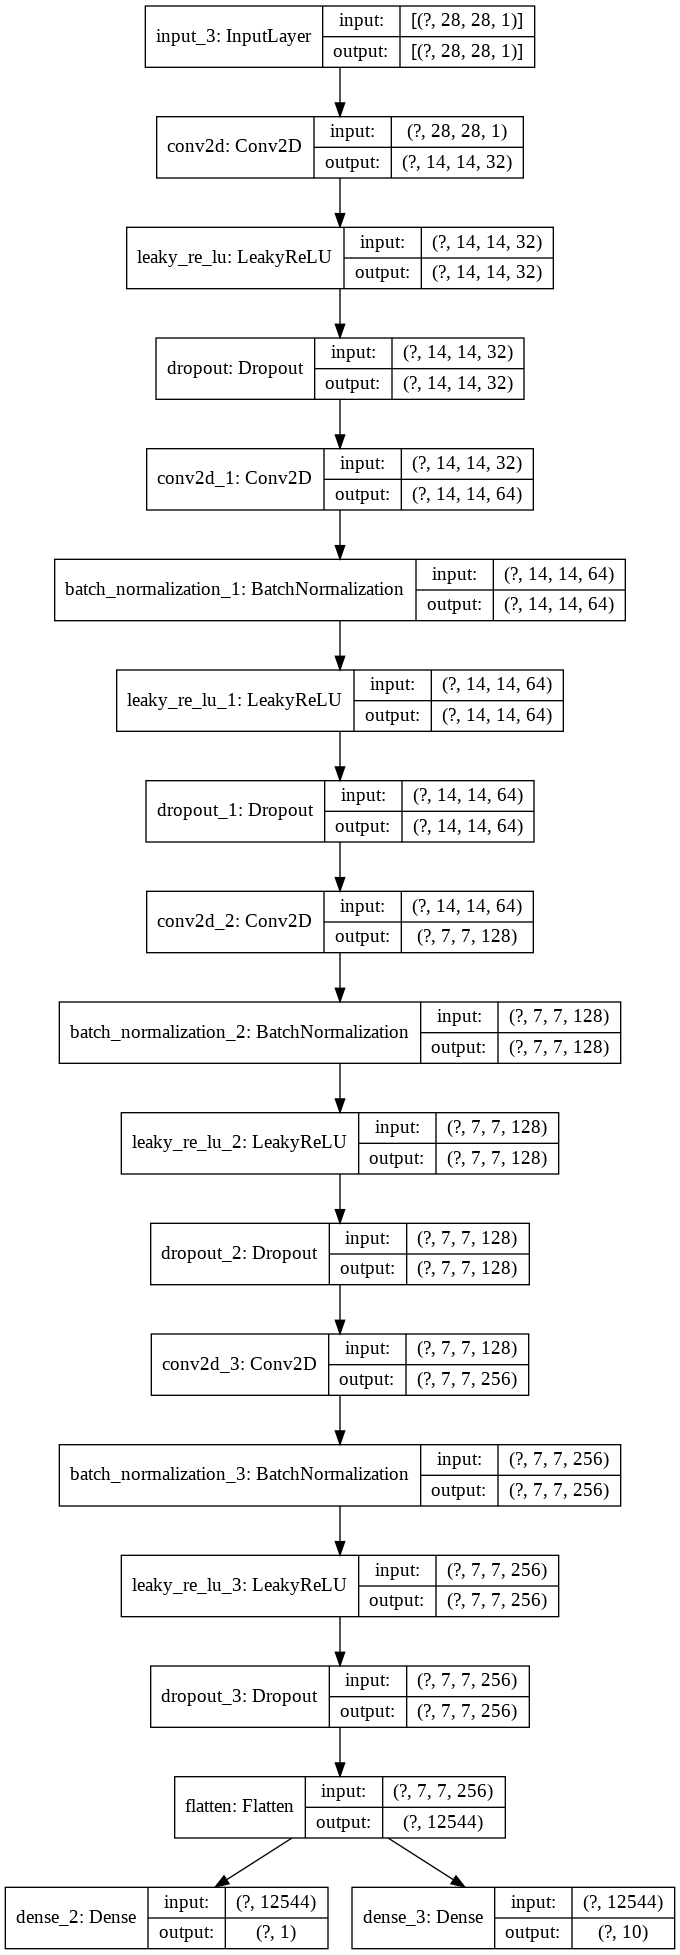

In [9]:
model = def_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
def AC_GAN(generator, discriminator):
  discriminator.trainable = False
  GAN_op = discriminator(generator.output)
  model = Model(generator.input, GAN_op)
  optimizer = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss = ['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer = optimizer)
  return model

In [11]:
def load_real_samples():
  (X_train, y_train), (_, _) = load_data()
  X = expand_dims(X_train, axis = -1)
  X = X.astype('float32')
  X = (X - 127.5) / 127.5
  print(X.shape, y_train.shape)
  return [X, y_train]

In [36]:
def generate_real_samples(data, num_samples):
  images, labels = data
  idx = randint(0, images.shape[0], num_samples)
  X, labels = images[idx], labels[idx]
  y = ones((num_samples, 1))
  return [X, labels], y 

In [24]:
def latent_points(latent_dims, num_samples, n_classes = 10):
  x_in = randn(latent_dims*num_samples)
  z_in = x_in.reshape(num_samples, latent_dims)
  labels = randint(0, n_classes, num_samples)
  return [z_in, labels]

In [25]:
def generate_fake_samples(generator, latent_dims, num_samples):
  z_in, labels = latent_points(latent_dims, num_samples)
  images = generator.predict([z_in, labels])
  y = zeros((num_samples, 1))
  return [images, labels], y 

In [15]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dims, num_samples=100):
	[X, _], _ = generate_fake_samples(g_model, latent_dims, num_samples)
	X = (X + 1) / 2.0
	for i in range(100):
		plt.subplot(10, 10, i+1)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
  
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
 
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('---> Saved: %s and %s' % (filename1, filename2))

In [41]:
def train_model(generator, discriminator, GAN_model, data, latent_dims, n_epochs = 100, n_batch = 64):

  batches_per_epoch = int(data[0].shape[0] / n_batch)
  steps = int(batches_per_epoch * n_epochs)
  half_batch = n_batch // 2
  for i in range(steps):
    [X_real, labels_real], y_real = generate_real_samples(data, half_batch)
    _, d_r1, d_r2 = discriminator.train_on_batch(X_real, [y_real, labels_real])
    [X_fake, labels_fake], y_fake = generate_fake_samples(generator, latent_dims, half_batch)
    _, d_f1, d_f2 = discriminator.train_on_batch(X_fake, [y_fake, labels_fake])
    [z_in, z_labels] = latent_points(latent_dims, n_batch)
    y_GAN = ones((n_batch, 1))
    _, g_1, g_2 = GAN_model.train_on_batch([z_in, z_labels], [y_GAN, z_labels])
    print('-->%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1, d_r2, d_f1 ,d_f2, g_1,g_2))
    # evaluate the model performance every 'epoch'
    if (i+1) % (batches_per_epoch * 10) == 0:
      summarize_performance(i, generator, latent_dims)

In [42]:
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint

In [43]:
latent_dims = 100
discriminator= def_discriminator()
generator = def_generator(latent_dims)
GAN_model = AC_GAN(generator, discriminator)
dataset = load_real_samples()
train_model(generator, discriminator, GAN_model, dataset, latent_dims)

Streaming output truncated to the last 5000 lines.
-->88703, dr[0.000,0.181], df[0.000,0.000], g[0.244,0.064]
-->88704, dr[0.000,0.226], df[0.000,0.000], g[0.314,0.037]
-->88705, dr[0.000,0.179], df[0.000,0.002], g[0.467,0.051]
-->88706, dr[0.000,0.279], df[0.000,0.000], g[0.309,0.026]
-->88707, dr[0.000,0.082], df[0.000,0.001], g[0.315,0.018]
-->88708, dr[0.000,0.057], df[0.000,0.000], g[0.212,0.067]
-->88709, dr[0.000,0.107], df[0.000,0.001], g[0.310,0.039]
-->88710, dr[0.000,0.159], df[0.000,0.011], g[0.275,0.025]
-->88711, dr[0.000,0.399], df[0.000,0.001], g[0.436,0.064]
-->88712, dr[0.000,0.661], df[0.000,0.001], g[0.274,0.030]
-->88713, dr[0.000,0.242], df[0.000,0.001], g[0.331,0.029]
-->88714, dr[0.000,0.203], df[0.000,0.005], g[0.301,0.057]
-->88715, dr[0.000,0.335], df[0.000,0.000], g[0.436,0.045]
-->88716, dr[0.000,0.603], df[0.000,0.000], g[0.410,0.055]
-->88717, dr[0.000,0.169], df[0.000,0.001], g[0.333,0.107]
-->88718, dr[0.000,0.226], df[0.000,0.000], g[0.098,0.035]
-->88